In [1]:
import pandas as pd
import os
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import numpy as np
import mne
from scipy.signal import welch
import seaborn as sns
import yasa
import glob
import time
import joblib

import sklearn
from sklearn.metrics import accuracy_score

#Imports to enable cross validation
from sklearn.model_selection import KFold, cross_val_score

os.environ['CONDA_DEFAULT_ENV']

'rbd_2clone'

/export/sphere/ebirah/ko20929/miniconda3/envs/rbd_2clone/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.1, the latest is 0.6.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/export/sphere/ebirah/ko20929/miniconda3/envs/rbd_2clone/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/export/sphere/ebirah/ko20929/miniconda3/envs/rbd_2clone/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [13]:
#Notes

#Every classifier will have it's own confusion matrix 

#5 EEG types x 13 regions x (Number of classifiers - MrSQL x 6?) x preproc type (2) * number of expt types 
# = 130 * MrSQL classifiers * 4 expts ... a lot!!
#I think I'm only interested in Prefrontal Region CM's TBH & I can make preproc type / MrSQL model name a parameter

# I need to loop through --> Folders containing processed data x 2 per data type, expt types x 4 , classifiers - MrSQL x 6

# What do I want to plot 
# For each type of data .... for each interesting clf ... Performance on the four experiments? 
# Store in dictionary for plotting CM's

# key --> data type , value : dictionary of classifiers where key is classifier name and value is dictionary where key is expt_type (integer) and value is dictionary where keys are y_preds and y_true 

# Example 

# {'N3_82_expt_files' : {'MRSQL_2_Prefrontal' : [1 : {'y_preds' : [0,1,2,2,1,2,1] , 'y_true' : [1,1,2,2,1,21]}, 
#  2 :{'y_preds' : [0,1,2,2,1,2,1] , 'y_true' : [1,1,2,2,1,21]} , 3 etc...] , 'MRSQL_3_Prefrontal' : etc...} }

In [66]:
main_expt_folders_config_dict

{'N2_120_expt_files': {'EEG Type': 'N2',
  'TS processing': 'Shorter_experiments'},
 'N3_82_expt_files': {'EEG Type': 'N3',
  'TS processing': 'Shorter_experiments'},
 'REM_19_expt_files': {'EEG Type': 'REM',
  'TS processing': 'Shorter_experiments'},
 'N1_8 expt_files': {'EEG Type': 'N1', 'TS processing': 'Shorter_experiments'},
 'N2_120_expt_files_v2': {'EEG Type': 'N2',
  'TS processing': 'Shorter_experiments'},
 'N1_customised_40_expt_files': {'EEG Type': 'N1',
  'TS processing': 'Shorter_experiments'},
 'EC_8_expts': {'EEG Type': 'EC_W', 'TS processing': 'Shorter_experiments'},
 'N1_full_expts': {'EEG Type': 'N1',
  'TS processing': 'Full Length experiments'},
 'N2_full_expts': {'EEG Type': 'N2',
  'TS processing': 'Full Length experiments'},
 'N3_full_expts': {'EEG Type': 'N3',
  'TS processing': 'Full Length experiments'},
 'REM_full_expts': {'EEG Type': 'REM',
  'TS processing': 'Full Length experiments'},
 'EC_full_expts': {'EEG Type': 'EC_W',
  'TS processing': 'Full Length e

In [2]:
#Import view results module and necessary variables etc.. from the module
import view_results
import constants 

class_label_dict = constants.class_label_dict

core_path = view_results.core_path

main_expt_folders_config_dict = view_results.main_expt_folders_config_dict
main_expt_folders = view_results.main_expt_folders

clfs_mrsql = view_results.clfs_mrsql
clfs_SAX = view_results.clfs_SAX

results_for_cm_plots = {}
for folder in main_expt_folders:
    results_for_cm_plots[folder] = {}
    for clf in list(clfs_mrsql.keys()) + list( clfs_SAX.keys() ):
        results_for_cm_plots[folder][clf] = {}

{'N2_120_expt_files': {'MrSQL_1': {},
  'MrSQL_2': {},
  'MrSQL_3': {},
  'MrSQL_4': {},
  'MrSQL_SAX': {}},
 'N3_82_expt_files': {'MrSQL_1': {},
  'MrSQL_2': {},
  'MrSQL_3': {},
  'MrSQL_4': {},
  'MrSQL_SAX': {}},
 'REM_19_expt_files': {'MrSQL_1': {},
  'MrSQL_2': {},
  'MrSQL_3': {},
  'MrSQL_4': {},
  'MrSQL_SAX': {}},
 'N1_8 expt_files': {'MrSQL_1': {},
  'MrSQL_2': {},
  'MrSQL_3': {},
  'MrSQL_4': {},
  'MrSQL_SAX': {}},
 'N2_120_expt_files_v2': {'MrSQL_1': {},
  'MrSQL_2': {},
  'MrSQL_3': {},
  'MrSQL_4': {},
  'MrSQL_SAX': {}},
 'N1_customised_40_expt_files': {'MrSQL_1': {},
  'MrSQL_2': {},
  'MrSQL_3': {},
  'MrSQL_4': {},
  'MrSQL_SAX': {}},
 'N1_full_expts': {'MrSQL_1': {},
  'MrSQL_2': {},
  'MrSQL_3': {},
  'MrSQL_4': {},
  'MrSQL_SAX': {}},
 'N2_full_expts': {'MrSQL_1': {},
  'MrSQL_2': {},
  'MrSQL_3': {},
  'MrSQL_4': {},
  'MrSQL_SAX': {}},
 'N3_full_expts': {'MrSQL_1': {},
  'MrSQL_2': {},
  'MrSQL_3': {},
  'MrSQL_4': {},
  'MrSQL_SAX': {}},
 'REM_full_expts': {'

In [3]:
t1 = time.time()

# Extract the results in a way that they can easily be plotted as confusion matrices
for main_folder in main_expt_folders:
        top_level_properties = main_expt_folders_config_dict[main_folder]
        main_folder_path = core_path+main_folder+'/'
        
        for folder in view_results.get_immediate_subdirectories(main_folder_path):
            
            if 'SAX' in folder:
                clfs = clfs_SAX
                #not looking at SAX model results rn bro 
                continue
            elif folder in ['expt_1' , 'expt_2' , 'expt_3' , 'expt_4']:
                continue
            elif 'Non_TS_expt' in folder:
                continue
            else:
                clfs = clfs_mrsql
                
            #set the experiment type (based on last string element of folder name)______________________________
            if folder == '.ipynb_checkpoints':
                continue               
            
            #Each folder has a results dataframe, load it and read corresponding results columns
            try:
                results_df = pd.read_hdf(main_folder_path + folder + '/raw_clfs_results.h5')
            except: 
                file_not_found.append(main_folder + '/' + folder)
                continue
                
            # Load the results __________________________________________________________________________________________________
            regional_clf_results = results_df
            
            # Loop through the classifiers to store the predictions and true y_values in the results dictionary___________________
            for clf in clfs:
                # column is defined as  region+ '_' + clf + '_y_preds' , currently doing only for region = 'Prefrontal'
                clf_col = 'Prefrontal' + '_' + clf +'_y_preds'
                clf_preds = np.concatenate( regional_clf_results[clf_col][0] + regional_clf_results[clf_col][1])
                y_true = pd.concat(regional_clf_results['y_true'][0] + regional_clf_results['y_true'][1])

                subset_results_dict = {'y_true' : y_true , 'y_preds' : clf_preds}
                #Populate the overall results dictionary 
                results_for_cm_plots[main_folder][clf][int(folder[-1])] = subset_results_dict

                # results_for_cm_plots['N2_120_expt_files']['MrSQL_2'][1] = {'y_preds': [1,2,3,1,2,1,1] , 'y_true' : [1,2,3,1,2,1,1]}

            
            #Plot the confusion matrix_________________________________________________________________________________________

#             display_labels_num = int(folder[-1])
#             display_labels_dict = {1 : ['HC' , 'PD'] , 2 : ['HC', 'PD+PD_RBD'],
#                                    3 : ['HC', 'PD+PD_RBD', 'RBD'], 4: ['HC', 'PD', 'PD_RBD', 'RBD']}
            
#             title = 'CM ' + main_folder + ' ' + folder
            
            
#             confusion_matrix = sklearn.metrics.confusion_matrix(y_true, clf_preds, normalize = None)
#             sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels = display_labels_dict[display_labels_num]).plot(cmap=plt.cm.Blues)

#             plt.title(title)   
#             plt.show()
#             print('finished')

t2 = time.time()

t2-t1

0.387495756149292

#### Plot a single CM from results dictionary

In [4]:
#The main title should say the folder , the classifier , the preprocessing 
#Each Subplot should state the experiment type  e.g. PD vs RBD - that'ts it

In [9]:
results_for_cm_plots.keys()
results_for_cm_plots['N3_82_expt_files'].keys()
results_for_cm_plots['N3_82_expt_files']['MrSQL_1'].keys()
print(results_for_cm_plots['N3_82_expt_files']['MrSQL_1'][1].keys())

dict_keys(['y_true', 'y_preds'])


In [75]:
# Plot multiple CM's side by side with code from here: 
# https://stackoverflow.com/questions/61825227/plotting-multiple-confusion-matrix-side-by-side

#### Plot four CMs in a row (one per expt_type)

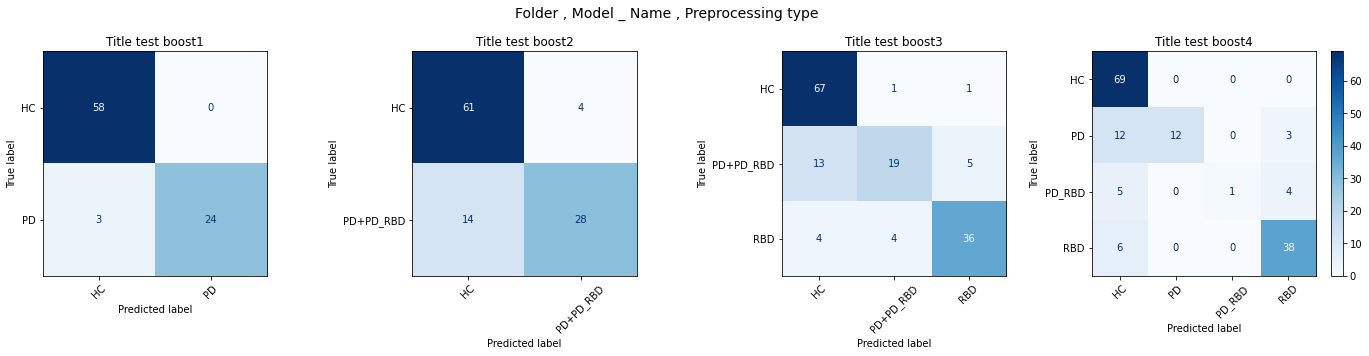

In [60]:
display_labels_dict = {1 : ['HC' , 'PD'] , 2 : ['HC', 'PD+PD_RBD'],
                       3 : ['HC', 'PD+PD_RBD', 'RBD'], 4: ['HC', 'PD', 'PD_RBD', 'RBD']}

f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey= False )

for i, ax in zip([1,2,3,4], f.axes):
    y_true = results_for_cm_plots['N3_82_expt_files']['MrSQL_1'][i]['y_true']
    y_preds = results_for_cm_plots['N3_82_expt_files']['MrSQL_1'][i]['y_preds']
    
    cf_matrix = sklearn.metrics.confusion_matrix(y_true, y_preds)
     
    disp = sklearn.metrics.ConfusionMatrixDisplay(cf_matrix,
                                  display_labels= display_labels_dict[i]
                                 )
    
    disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Blues)
    
    disp.ax_.set_title('Title test boost' + str(i))
    if i != 4:
        disp.im_.colorbar.remove()
    plt.tight_layout()


plt.suptitle("Folder , Model _ Name , Preprocessing type", fontsize=14)
    
plt.subplots_adjust(wspace=0.40, hspace=0.1)

plt.tight_layout()

plt.savefig('Test_cm.png', dpi=200 )

#### Turn CMs in a row plotting into a function

In [104]:
def plot_cms(results_dict , folder , classifier, save_name = False):
    expt_info = [ '1. PD vs HC' , '2. (PD , PD+RBD) vs HC' , '3. (PD + PD&RBD) vs HC vs RBD  multiclass' , 
             '4. PD vs PD+RBD vs RBD vs HC  multiclass'    ]
    
    display_labels_dict = {1 : ['HC' , 'PD'] , 2 : ['HC', 'PD+PD_RBD'],
                       3 : ['HC', 'PD+PD_RBD', 'RBD'], 4: ['HC', 'PD', 'PD_RBD', 'RBD']}
    
    main_expt_folders_config_dict = view_results.main_expt_folders_config_dict

    f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey= False )

    for i, ax in zip([1,2,3,4], f.axes):
        y_true = results_dict[folder][classifier][i]['y_true']
        y_preds = results_dict[folder][classifier][i]['y_preds']

        cf_matrix = sklearn.metrics.confusion_matrix(y_true, y_preds)

        disp = sklearn.metrics.ConfusionMatrixDisplay(cf_matrix,
                                      display_labels= display_labels_dict[i]
                                     )

        disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Blues)

        disp.ax_.set_title(expt_info[i-1])
        if i != 4:
            disp.im_.colorbar.remove()
        plt.tight_layout()


    plt.suptitle(folder + ' , ' + classifier + ' , ' + main_expt_folders_config_dict[folder]['TS processing'] , fontsize=14)

    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    plt.tight_layout()
    
    if save_name != False:   
        plt.savefig(save_name , dpi=200 )

In [78]:
#Prefrontal x 5 data types x 5 classifiers x 2 preproc = 50 CM files , each with 4 CMs

## Use the function to plot all of the confusion matrices

In [94]:
list(results_for_cm_plots.keys() )[6][:3]

'N1_'

In [83]:
folder

'MrSQL_SAX_expt_2'

In [79]:
# file names will follow the convention 
# Model Data Type _ folder 
# ==> MrSQL_SAX _ N1 _ N1_full_expts

In [105]:
%%capture

t1 = time.time()

folders_classfiers_not_plotted = []
for folder in results_for_cm_plots.keys():
    for classifier in results_for_cm_plots[folder].keys():
        try :
            file_name = 'CM_Plots/' + classifier + '_' + folder[:3] + '_' + folder + '.png'
            plot_cms(results_for_cm_plots , folder , classifier, save_name = file_name)
        except:
            #add info to some list
            folders_classfiers_not_plotted.append((folder, classifier))

t2 = time.time()

t2-t1

In [102]:
folders_classfiers_not_plotted

[('N2_120_expt_files', 'MrSQL_1'),
 ('N2_120_expt_files', 'MrSQL_2'),
 ('N2_120_expt_files', 'MrSQL_3'),
 ('N2_120_expt_files', 'MrSQL_4'),
 ('N2_120_expt_files', 'MrSQL_SAX'),
 ('N3_82_expt_files', 'MrSQL_SAX'),
 ('REM_19_expt_files', 'MrSQL_SAX'),
 ('N1_8 expt_files', 'MrSQL_1'),
 ('N1_8 expt_files', 'MrSQL_2'),
 ('N1_8 expt_files', 'MrSQL_3'),
 ('N1_8 expt_files', 'MrSQL_4'),
 ('N1_8 expt_files', 'MrSQL_SAX'),
 ('N2_120_expt_files_v2', 'MrSQL_SAX'),
 ('N1_customised_40_expt_files', 'MrSQL_SAX'),
 ('N1_full_expts', 'MrSQL_SAX'),
 ('N2_full_expts', 'MrSQL_SAX'),
 ('N3_full_expts', 'MrSQL_SAX'),
 ('REM_full_expts', 'MrSQL_SAX'),
 ('EC_full_expts', 'MrSQL_SAX'),
 ('EC_8_expts', 'MrSQL_SAX')]